<h1>Assignment 4</h1>
<h2>Pima Indians Diabetes</h2>
<br>
<p>I am interested in this dataset because my father has suffered with Diabetes since he was a child.</p>
<p>https://www.kaggle.com/uciml/pima-indians-diabetes-database</p>
    

<h4>Imports</h4>

In [1]:
from sklearn.cluster import KMeans
import numpy as np
import warnings

### Exercise 1: Clustering, Bisecting k-Means

<h4>Helper Functions</h4>

In [2]:
def feature_normalization(X):
    # compute mean and stdev over axis 0, the feature vector (down the column)
    mean = np.mean(X,0)
    stddev = np.std(X,0)
    
    # elementwise difference
    diff = np.subtract(X,mean)
    
    # elementwise division
    normalized = np.divide(diff,stddev)
    
    # for testing
    # for each feature, stddev should be 1 and mean should be 0
    #print("stddev of normalized", np.std(normalized,0))    
    #print("mean of normalized", np.mean(normalized,0))    
    
    return normalized  

In [3]:
def kmeans_2_clusters(X, max_iter, random_state = 42):
    km = KMeans(n_clusters=2, max_iter = max_iter, random_state=random_state)
    km.fit(X)
    return km.labels_

#### BKMEANS FUNCTION

In [4]:
def bkmeans(X, k, max_iter, random_state = 42):
    # K should be greater than 1, otherwise it can be considered already a cluster
    assert k>1
    
    # Step 1, initialize by dividing in to two clusters
    clusters = kmeans_2_clusters(X, max_iter)
    cluster_counter = 2
    
    # Step 2, Iterate until reached num of clusters desired
    while cluster_counter < k:
        # Get largest cluster
        cluster_ids, cluster_counts = np.unique(clusters, return_counts = True)
        largest_cluster_index = np.argmax(cluster_counts)
        
        # This is actually unnecessary because the id always matches the index
        largest_cluster_id = cluster_ids[largest_cluster_index]
        
        # Get indices of elements in the largest cluster 
        indices = np.nonzero(clusters == largest_cluster_id)[0]
        
        # Get values of subcluster for use in Kmeans
        values_largest_cluster = X[indices]
        
        # Split subcluster into two smaller clusters
        subcluster_labels = kmeans_2_clusters(values_largest_cluster, max_iter)
        
        # Get indices of new subcluster that is mapped to 0 (arbitrary, can choose 0 or 1)
        subcluster_label_indices = np.nonzero(subcluster_labels == 0)[0]

        # Map indices of new subcluster back to the main cluster array
        original_indices = indices[subcluster_label_indices]
        
        # Update main cluster array with new subcluster assignments
        clusters[original_indices] = cluster_counter
        cluster_counter += 1
    
    return clusters
    

In [5]:
def ex1():
    # load data
    data = np.loadtxt('./diabetes.csv',delimiter=',',skiprows=1)
    X = data[:, 0:-1]
    #y = data[:, -1]

    # Normalize Data
    Xn = feature_normalization(X)
    
    # Get Clusters
    clusters = bkmeans(Xn, 10, 10)
    
    print("A4, EX1\nclusters.shape",clusters.shape,"\nclusters",clusters)

In [6]:
#ex1()

# Exercise 2: Non-linear Dimensionality Reduction

<p>The algorithm can be implemented with gradient descent using the following steps:</p>
<ol><li>Start with a random two-dimensional layout Y of points (Y is a n × 2 matrix).</li>
    <li>Compute the stress E of Y . See slide 47 of Lecture 12 for the formula.</li>
    <li>If E < ε, or if the maximum number of iterations iter has been reached, stop.</li>
    <li>For each yi of Y , find the next vector yi(t + 1) based on the current yi(t). See slide 48 of lecture 12</li><li>Go to Step 2.</li></ol>


In [174]:
def get_distance_matrix(X, Y):
    """ Create distance matrix 
    Note:
        1. Optimization level - highly optimized! I used this during assignment 1. 
        Algorithm was found https://medium.com/@souravdey/l2-distance-matrix-vectorization-trick-26aa3247ac6c
        It is a no loop solution, which means it can handle the matrices in
        one line of code rather than having to iterate over the rows of one
        matrix
    """
    
    #print("get_distance_matrix")
    #print(X.shape)
    #print(Y.shape)
    
    # perform operation in parts due to tiny numbers causing error with sqrt
    eu1 = -2 * np.dot(Y, X.T) + np.sum(X**2, axis=1) + np.sum(Y**2, axis=1)[:, np.newaxis]
    
    # replace tiny numbers with 0
    eu1 = np.where(np.absolute(eu1)<1e-10,0,eu1)
    
    # return sqrt of 'clean' matrix
    return np.sqrt(eu1)

def get_c(X):
    # C is the sum of all elements of the upper triangular distance matrix
    return np.sum(np.triu(X))

A4, EX2
stress 10.758427362391714
stress 19.552996048585463
stress 30.53457776973274
stress 43.19417771089304
stress 63.531453581965486
stress 92.6066791043724
stress 131.2593256715524
stress 1.6232404511616496e+302


/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: overflow encountered in multiply
/Library/www/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Library/www/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:128: RuntimeWarning: overflow encountered in multiply


stress inf


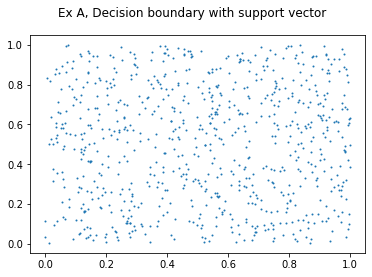

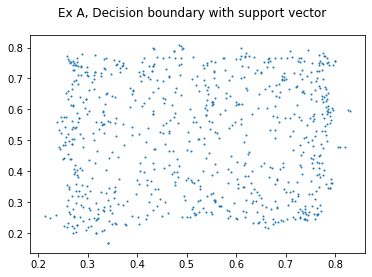

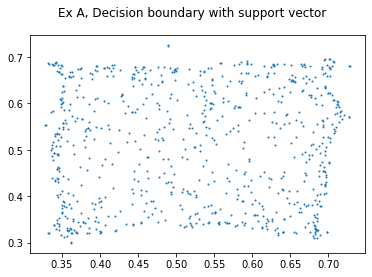

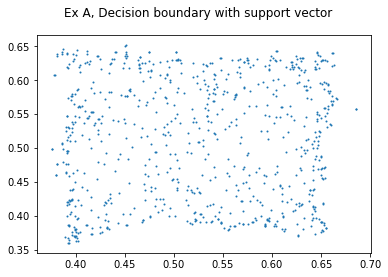

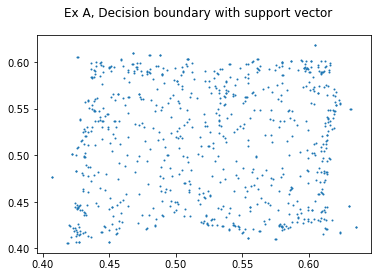

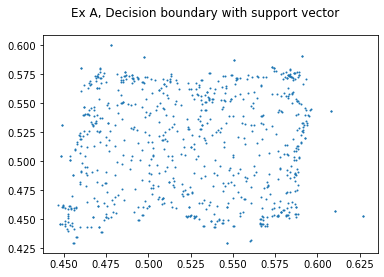

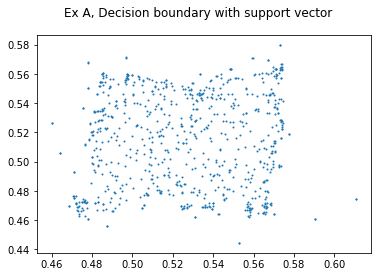

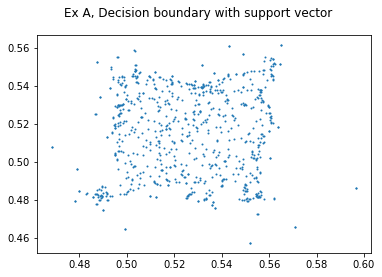

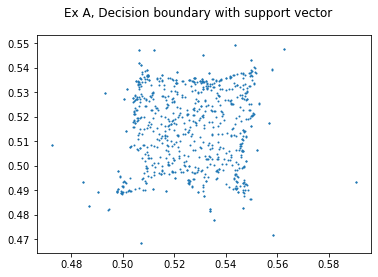

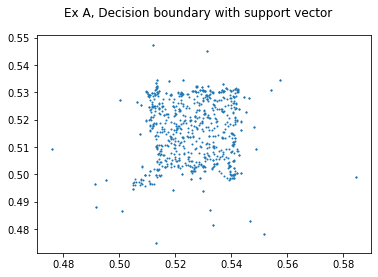

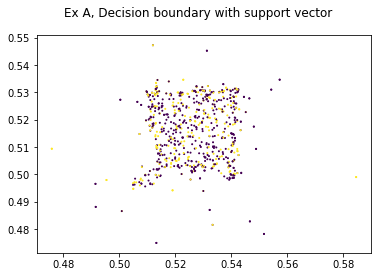

In [176]:
   
def sammon(hd_matrix, max_iter=20, eps=.3, alpha=0):
    hd_delta_matrix = get_distance_matrix(hd_matrix, hd_matrix)
    #print("hd_delta_matrix",hd_delta_matrix)

    c = get_c(hd_delta_matrix)
    #print("c",c)
    
    original_reduced_matrix = reduced_matrix = np.random.rand(len(hd_matrix),2)
    #print("reduced_matrix",reduced_matrix)
    # plot boundary with support vector    
    fig = plt.figure()
    fig.suptitle("Ex A, Decision boundary with support vector")
    ax = fig.add_subplot(1, 1, 1)

    # plot support vectors
    ax.scatter(reduced_matrix[:,0], reduced_matrix[:,1], s=1)
    
    for curr_iter in range(1,max_iter):
        reduced_delta_matrix = get_distance_matrix(reduced_matrix, reduced_matrix)
        print("stress", stress(c, reduced_delta_matrix, hd_delta_matrix))
        yitp1 = gradient(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, eps, c)
        reduced_matrix = yitp1
        
        # plot boundary with support vector    
        fig = plt.figure()
        fig.suptitle("Ex A, Decision boundary with support vector")
        ax = fig.add_subplot(1, 1, 1)

        # plot support vectors
        ax.scatter(reduced_matrix[:,0], reduced_matrix[:,1], s=1)
    
   # print("original_reduced_matrix", original_reduced_matrix)
    #print("reduced_matrix", reduced_matrix)
    #print("diff", original_reduced_matrix - reduced_matrix)
    
    return reduced_matrix

def gradient(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, eps, c ):
    
    return reduced_matrix - eps * pd1(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, c)/pd2(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, c)
    
def pd1(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, c):
    a = (-2/c)
    #print("a", a)
    
    b = hd_delta_matrix - reduced_delta_matrix
    #print("b", b)
    
    cc = reduced_delta_matrix * hd_delta_matrix
    #print("cc", cc)
    
    # We should not be dividing by zero, however, this causes a runtime warning only 
    # on Jupyter and only affects the elements along the diagonal (or maybe other datapoints with 0 distance)
    # Therefore, this operation does not block an otherwise efficient way to compute this as a matrix operation
    # We simply perform the division, ignore the warning in place, and then fix the divide by zero cells, changing
    # them from nan back to 0. Then we can sum over the matrix later using numpy and avoid for loops
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            d = b / cc
            #print("d", d)
        except Warning as e:
            print('error found:', e)
    
    e = np.nan_to_num(d)
    #print("e shape",e.shape)
    #print("e",e)
    
    ee = e[:,:,np.newaxis]
    #print("ee shape",e.shape)
    #print("ee",ee)
    
    f = reduced_matrix - reduced_matrix[:,np.newaxis]
    #print("fshape",f.shape)
    #print("f",f)
    
    g = ee*f
    #print("g shape",g.shape)
    #print("g",g)
    
    h = np.sum(g,axis=0)
    #print("h shape",h.shape)
    #print("h",h)
    
    i = a * h
    #print("i shape",i.shape)
    #print("i",i)
    
    return i

def pd2(reduced_matrix, hd_delta_matrix, reduced_delta_matrix, c):
    a = (-2/c)
    b = hd_delta_matrix * reduced_delta_matrix
    
    # We should not be dividing by zero, however, this causes a runtime warning only 
    # on Jupyter and only affects the elements along the diagonal (or maybe other datapoints with 0 distance)
    # Therefore, this operation does not block an otherwise efficient way to compute this as a matrix operation
    # We simply perform the division, ignore the warning in place, and then fix the divide by zero cells, changing
    # them from nan back to 0. Then we can sum over the matrix later using numpy and avoid for loops
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            cc = 1 / b
            #print("d", d)
        except Warning as e:
            print('error found:', e)
    
    cc = np.nan_to_num(cc)
    e = hd_delta_matrix - reduced_delta_matrix
    f = reduced_matrix - reduced_matrix[:,np.newaxis]
    f = f**2
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            g = f/reduced_delta_matrix[:,:,np.newaxis]
        except Warning as e:
            print('error found:', e)

    g = np.nan_to_num(g)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            h = (hd_delta_matrix - reduced_delta_matrix)/reduced_delta_matrix
        except Warning as e:
            print('error found:', e)
    h = np.nan_to_num(h)    
    i = (1+h)[:,:,np.newaxis]
    j = g * i
    e = e[:,:,np.newaxis]
    k = e - j 
    cc = cc[:,:,np.newaxis]
    l = cc * k
    m = np.sum(l,axis=0)
    n = a*m
    return n

def stress(c, hd_delta_matrix, reduced_delta_matrix):
    #print("stress")
    a = (1/c)
    #print("a",a)
    b = (hd_delta_matrix-reduced_delta_matrix)**2
    #print("b",b)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            c = b/hd_delta_matrix
        except Warning as e:
            print('error found:', e)
    c = np.nan_to_num(c)
    #print("c",c)
    c = np.triu(c)
    #print("c triu",c)
    return a * np.sum( c )
    
    
def ex2_norm():
    print("A4, EX2")
    
    # load data
    data = np.loadtxt('./diabetes.csv',delimiter=',',skiprows=1)
    X = data[:, 0:-1]
    
    y = data[:, -1]

    # Normalize Data
    Xn = feature_normalization(X)
    
    # Get Clusters
    reduced_matrix = sammon(Xn, max_iter=10)
    
    
    # plot boundary with support vector    
    fig = plt.figure()
    fig.suptitle("Ex A, Decision boundary with support vector")
    ax = fig.add_subplot(1, 1, 1)

    # plot support vectors
    ax.scatter(reduced_matrix[:,0], reduced_matrix[:,1], s=1, c=y)
    
    
ex2_norm()

# Exercise 3: Visualization of Results

In [117]:
import matplotlib.pyplot as plt
from sklearn import datasets

A4, EX3
stress 7.266976995859794
stress 13.904269273971655
stress 22.803662029301446


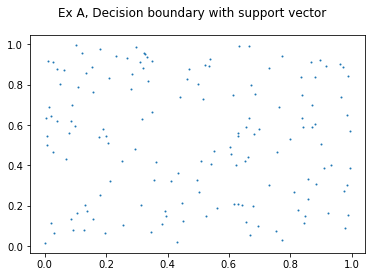

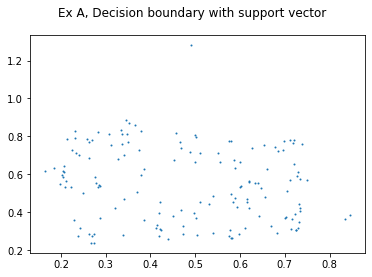

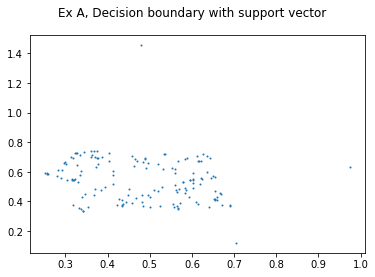

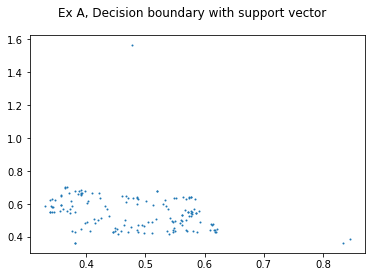

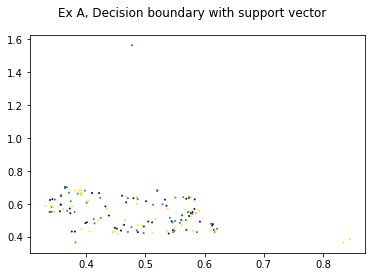

In [177]:
def ex3():
    print("A4, EX3")
    
    # load data
    # import some data to play with
    iris = datasets.load_iris()
    X = iris.data  # we only take the first two features.
    y = iris.target

    # Normalize Data
    Xn = feature_normalization(X)
    #Xn = X
    
    # Get Clusters
    reduced_matrix = sammon(Xn,max_iter=4)
    
    
    # plot boundary with support vector    
    fig = plt.figure()
    fig.suptitle("Ex A, Decision boundary with support vector")
    ax = fig.add_subplot(1, 1, 1)

    # plot support vectors
    ax.scatter(reduced_matrix[:,0], reduced_matrix[:,1], s=1, c = y)
ex3()